In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [2]:
all_files = glob.glob("../roll_data/*-steal_attempt.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

# seasons = [11]
# seasons = [12]
# seasons = [11, 12, 13, 14]
# seasons = [13]
seasons = [13, 14]
df = df[df["season"].isin(seasons)]
len(df)

173846

In [3]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass  # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_runner_mul(row):
    # if row[["runner_name"]].isna().any():
    # row["runner_name"] == "NaaN"
    bm = str(row["runner_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            mul += 0.35
    if "GROWTH" in btm:
        # is this actually 0.035 instead of 0.05?
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        mul += 1.0
        attrs = "runner_musclitude, runner_divinity, runner_ground_friction"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        mul += 0.80
        attrs = "runner_musclitude, runner_laserlikeness, runner_ground_friction, runner_continuation"
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
        # pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    # if row["runner_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    # NVGs allow the player to play 50% better in a solar eclipse.
    # This might affect fielding and baserunning as well?
    # mul += 0.50
    return mul, attrs


def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == 18 and str(row["baserunner_count"]) > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    # NVGs allow the player to play 50% better in a solar eclipse.
    # This might affect fielding and baserunning as well?
    # mul += 0.50
    return mul

In [4]:
# df["runner_mul"] = df.apply(get_runner_mul, axis=1)
df[["runner_mul", "runner_mul_attrs"]] = df.apply(get_runner_mul, axis=1, result_type="expand")
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)

In [5]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["runner_mods"].astype(str).str.contains("SCATTERED"), "runner_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

df["incon_center"] = df["ballpark_inconvenience"] - 0.5
df["elong_center"] = df["ballpark_elongation"] - 0.5

In [6]:
for attr in [
    "runner_base_thirst",
    "runner_continuation",
    "runner_ground_friction",
    "runner_indulgence",
    "runner_laserlikeness",
]:
    # had to do all this to make chunky and smooth work correctly
    df[attr + "_mul_vibe"] = df.apply(
        lambda x: x[attr] * x["runner_mul"] * (1 + 0.2 * x["runner_vibes"])
        if (x["runner_mul_attrs"] == "") or (attr in x["runner_mul_attrs"])
        else x[attr] * (1 + 0.2 * x["runner_vibes"]),
        axis=1,
    )
for attr in [
    # "runner_patheticism",
    # "runner_tragicness",
]:
    # had to do all this to make chunky and smooth work correctly
    df[attr + "_mul_vibe"] = df.apply(
        lambda x: x[attr] / x["runner_mul"] * (1 + 0.2 * x["runner_vibes"])
        if (x["runner_mul_attrs"] == "") or (attr in x["runner_mul_attrs"])
        else x[attr] * (1 + 0.2 * x["runner_vibes"]),
        axis=1,
    )
    # df[attr + "_mul_vibe"] = df[attr] * df["runner_mul"] * (1 + 0.2 * df["runner_vibes"])

In [7]:
df = df.copy()
for attr in [
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
]:
    # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])
    #                           if (x["pitcher_mul_attrs"] == "") or (attr in x["pitcher_mul_attrs"])
    #                           else x[attr] * (1 + 0.2 * df["pitcher_vibes"]),
    #                           axis=1)
    df[attr + "_mul_vibe"] = df[attr] * df["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])

In [8]:
if "fielder_vibes" in df:
    for attr in [
        "fielder_anticapitalism",
        "fielder_chasiness",
        "fielder_omniscience",
        "fielder_tenaciousness",
        "fielder_watchfulness",
    ]:
        # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])
        #                       if (x["fielder_mul_attrs"] == "") or (attr in x["fielder_mul_attrs"])
        #                       else x[attr] * (1 + 0.2 * df["fielder_vibes"]),
        #                       axis=1)
        df[attr + "_mul_vibe"] = df[attr] * df["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])

df = df.copy()

In [9]:
df.groupby("event_type").size().sort_values(ascending=False)[0:15]

event_type
StealAttempt0    86441
StealAttempt1    45136
StealAttempt2    42269
dtype: int64

In [10]:
dfc = df[df["event_type"] == "StealAttempt1"].copy()
for exclude_mod in [
    # "OVERPERFORMING",
    # "UNDERPERFORMING",
    # "HIGH_PRESSURE",
    # "GROWTH",
    # "SINKING_SHIP",
    # "TRAVELING",
    # "ON_FIRE",
    # "CHUNKY",
    # "SMOOTH",
    "SHELLED",
]:
    # for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
    # for exclude_mod in ["SPICY", "ON_FIRE"]:
    # dfc = dfc[~dfc["runner_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# dfc["laser_thirst"] = dfc["runner_laserlikeness_mul_vibe"] * dfc["runner_base_thirst_mul_vibe"]
# dfc["laser_thirst"] = dfc["runner_laserlikeness_mul_vibe"] * dfc["runner_base_thirst"]
# dfc["laser_thirst"] = dfc["runner_laserlikeness"] * dfc["runner_base_thirst"]


# dfc = dfc[(dfc["pitcher_mul"] == 1) & (dfc["runner_mul"] == 1) & (dfc["fielder_mul"] == 1)].copy()

# dfc = dfc[~dfc["stadium_id"].isna()].copy()

dfc = dfc[dfc['roll'] > 0.001].copy()
if 13 in seasons:
    dfc = dfc[dfc['day'] != 98].copy()
# dfc["roll_log"] = np.log(dfc["roll"])
# dfc["lt_log"] = np.log(dfc["laser_thirst"])
# dfc["laser_log"] = np.log(dfc["runner_laserlikeness"])

# dfc["thirst_log"] = np.log(dfc["runner_base_thirst"])

# dfc["watch"] = (
#     # 3 * dfc["pitcher_watchfulness_mul_vibe"]
#     # + 1 * dfc["fielder_watchfulness_mul_vibe"]
#     3 * dfc["pitcher_watchfulness"]
#     + 1 * dfc["fielder_watchfulness"]
# ) / 1
# dfc["watch_log"] = np.log(dfc["watch"])
# dfc["watch_pow"] = dfc["watch"]**1.5
# dfc["lt_pow"] = dfc["laser_thirst"]**1.5

# dfc = dfc[dfc["laser_thirst"] > 1e-3].copy()
len(dfc)
# dfc["laser_thirst"].min()
# dfc.groupby("ballpark_inconvenience").size()

44350

In [35]:
dfc["pwatch"] = dfc["pitcher_watchfulness"] * dfc["pitcher_mul"] # * (1 + 0.2*dfc["pitcher_vibes"])
dfc["fwatch"] = dfc["fielder_watchfulness"] * dfc["fielder_mul"] * (1 + 0.2 * dfc["fielder_vibes"])
dfc["watch"] = (7 * dfc["pwatch"] + 2 * dfc["fwatch"]) / 9
dfc["pwatch_sq"] = dfc["pitcher_watchfulness"]**2# * (1 + 0.2*dfc["pitcher_vibes"])

# dfc["roll_mod"] = (dfc["roll"] - 0.05 + 0.08 * dfc["watch"])
dfc["roll_mod"] = dfc["roll"] + 0.08 * dfc["watch"]

dfc["laser_vibe"] = dfc["runner_laserlikeness_mul_vibe"]
# dfc["laser"] = dfc["runner_laserlikeness_mul_vibe"]
dfc["laser"] = dfc["runner_laserlikeness"] * (1 + 0.2 * dfc["runner_vibes"])
dfc["thirst"] = dfc["runner_base_thirst"]
dfc["lasersq"] = dfc["laser"] ** 2
dfc["lasersq_thirst"] = dfc["lasersq"] * dfc["thirst"]
# dfc["lasersq_thirst"] = dfc["runner_base_thirst"] * (dfc["runner_laserlikeness_mul_vibe"] ** 2)

dfc["laser_thirst"] = dfc["laser"] * dfc["thirst"]
dfc["laser_thirstsq"] = dfc["laser"] * (dfc["thirst"] ** 2)
dfc["thirstsq"] = dfc["thirst"] ** 2

dfc["thirstpow"] = dfc["thirst"] ** 0.9


dfc["park_factors"] = dfc["incon_center"] + 2 * dfc["elong_center"]
# dfc["park_factors"] = dfc["ballpark_inconvenience"] + 2 * dfc["ballpark_elongation"]

# dfc["laser_thirst_term"] = dfc["thirst"] * (dfc["laser"]**2) * (1 + 0.2 * dfc["runner_vibes"])
dfc["laser_thirst_term"] = dfc["thirst"] * (3 * dfc["laser"] ** 2 + dfc["laser"]) / 4

# dfc["thirst_elong"] = dfc["thirst"] * dfc["ballpark_elongation"]
# dfc["thirst_incon"] = dfc["thirst"] * dfc["ballpark_inconvenience"]
# dfc["laser_elong"] = dfc["laser"] * dfc["ballpark_elongation"]
# dfc["laser_incon"] = dfc["laser"] * dfc["ballpark_inconvenience"]

# dfc["roll_log"] = np.log(dfc["roll_mod"])
# dfc["laser_log"] = np.log(0.205 + dfc["laser"]* (1+0.2*dfc["runner_vibes"]))
dfc = dfc[dfc['laser'] < 1.0].copy()

dfc = dfc[dfc['thirst'] < 1.0].copy()

In [56]:
X = dfc[
    [
        "passed",
        "roll",
        # "roll_mod",
        "laser",
        # "runner_laserlikeness",
        # "lasersq",
        # "laser_thirst",
        "lasersq_thirst",
        # "laser_thirst_term",
        # "laser_thirstsq",
        "thirst",
        # "thirstsq",
        # "thirstpow",
        # "laser_elong",
        # "laser_incon",
        # "watch",
        "pwatch",
        # "pitcher_watchfulness",
        # "pwatch_sq",
        "fwatch",
        # "watch_log",
        # "watch_pow",
        "park_factors",
        # "ballpark_inconvenience",
        # "ballpark_elongation",
        # "incon_center",
        # "elong_center",
        # "runner_vibes",
    ]
]
# X = X[X['roll'] > 0.001].copy()
# X = X[~X["roll_adj_log"].isna()]
y = X["passed"]
y = y.astype("int")
X = X.drop("passed", axis=1)

pin_intercept = None
# pin_intercept = 0.03755015
# pin_intercept = 0.04
pins = [
    # (0.01723101239886318, "laser"),
    # (1/75, "laser"),
    # (0.01333, "laser"),
    # (0.0135, "laser"),
    (0.00, "laser"),
    # (0.01, "runner_laserlikeness"),
    # (0.012, 'lasersq'),
    # (0.035, 'laser_thirst'),
    # (0.07402599926524667, 'lasersq_thirst'),
    # (0.08, 'lasersq_thirst'),
    # (0.095, 'lasersq_thirst'),
    # (0.0667, 'lasersq_thirst'),
    # (0.0232, 'thirst'),
    # (0.0167, 'thirst'),
    # (0.011, "thirst"),
    # (-0.0333, 'park_factors'),
    # (-0.062, 'pwatch'),
    # (-0.01932797561676943, 'fwatch'),
    # (-0.01933, 'fwatch'),
    # (-0.02, 'fwatch'),
    # (-0.08, 'watch'),
    # (0.006, 'laser_thirst_term'),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-12, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
dfc["threshold_plot"] = dfc["threshold"].copy()
dfc.loc[dfc["threshold"] < 0.001, "threshold"] = 0.001

[[29610     2]
 [    1   419]]
3 outliers
0.9999001065530101
intercept: 0.039132674086070546
(0.0, 'laser')
(0.0672979492164495, 'lasersq_thirst')
(0.011244266537859635, 'thirst')
(-0.061106556564337534, 'pwatch')
(-0.01966057126407647, 'fwatch')
(-0.033980826079400395, 'park_factors')


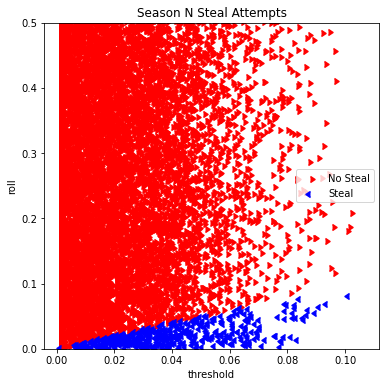

In [57]:
# kidror's fit, for steals of 3rd! not of 2nd!!! still can't replicate the "3 outliers" they got though
# 0.03755015 + 0.07402599926524667*runner + 0.020629673547652366*dfc["thirst"]
# + 0.01723101239886318*dfc["runner_laserlikeness"] - 0.06*dfc["pitcher_watchfulness"]
# - 0.01932797561676943*dfc["fwatch"]
# thirst and fwatch are thirst and fielder watchfulness with vibes, runner is base_thirst * laser^2

# season 13, null stadium only
# [[26065     0]
#  [    0  1153]]
# 0 outliers
# 1.0
# intercept: 0.043272646512567126
# (0.002301879255231324, 'laser_vibe'),
# (0.0076657470915077715, 'lasersq'),
# (0.0269960061526303, 'laser_thirst'),
# (0.07758523709024914, 'lasersq_thirst'),
# (-0.0032036086834798284, 'laser_thirstsq'),
# (0.0171756417623993, 'runner_base_thirst'),
# (-0.06039525672661708, 'pwatch'),
# (-0.019936549618782263, 'fwatch'),

# dfc["threshold"] = intercept_scaled[0]
# print("intercept:", intercept_scaled)
# for pair in pins + list(zip(-np.array(coef_list), X.columns)):
#     if "roll" not in pair[1]:
#         print(pair)
#         dfc["threshold"] += pair[0] * dfc[pair[1]]

y_val = "roll"
x_val = "threshold"
# x_val = "laser"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Steal",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Steal",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Season N Steal Attempts")
# ax.set_xlim(0.484, 0.499)
# ax.set_xlim(0, 0.01)
ax.set_ylim(0, 0.5)
# ax.set_xlim(-0.1, 0.1)
# ax.set_yscale("log")
# ax.set_xscale("log")
# if x_val == "threshold":
# ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

Text(0, 0.5, 'offset')

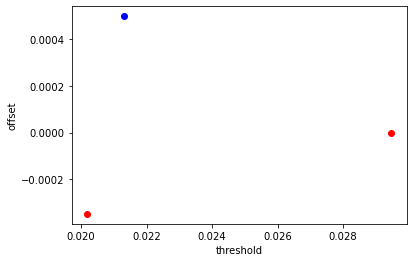

In [58]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
# x_val = "fwatch"
# x_val = "laser"
# x_val = "fielder_vibes"
# x_val = "thirst"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Steal",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Steal",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
# ax.legend()
# ax.set_ylim(0,2)

In [59]:
# pd.set_option("display.max_rows", None)  # default 60
pd.set_option("display.max_columns", 20)  # default 20
table = outliers[
    [
        "passed",
        "offset",
        "roll",
        "threshold",
        # "threshold_plot",
        # "event_type",  # "home_score", "away_score", "top_of_inning", "inning",
        "pitcher_mul",
        "runner_mul",
        "fielder_mul",  # "baserunner_count",
        # "runner_vibes", "pitcher_vibes",
        "laser",
        "runner_base_thirst",
        # "laser_thirst_term",
        # "pwatch",
        # "fwatch",
        # "incon_center",
        # "elong_center",
        # "park_factors",
        "runner_name",
        "pitcher_name",
        "fielder_name",
        # "runner_mods",
        # "pitcher_mods",
        # "fielder_mods",
        # "batting_team_mods",
        # "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        "stadium_id",
        "weather",
        # "fielder_roll",
    ]
]
print("number of outliers:", len(table))
# print(table.groupby("season").size())
table.sort_values("offset", ascending=False)  # [0:10]

number of outliers: 3


,passed,offset,roll,threshold,pitcher_mul,runner_mul,fielder_mul,laser,runner_base_thirst,runner_name,pitcher_name,fielder_name,season,day,game_id,play_count,stadium_id,weather
276995,True,0.000497,0.021791,0.021294,1.00,1.0,1.0,0.420770,0.219039,Denzel Scott,Agan Harrison,Lou Roseheart,14,14,01446566-6c61-4ff0-a151-b9acc94fa02f,9,06c991f6-4ef3-4a9a-8254-8a2bc7d3a1e1,Weather.BIRDS
326694,False,-0.000001,0.029469,0.029470,1.00,1.0,1.0,0.625042,0.840648,Basilio Fig,Jordan Hildebert,Jomgy Rolsenthal,13,89,191e39e1-bfea-4ac1-9ef9-2960d40ee07f,222,36b94380-39a6-4e32-b525-3e888215798a,Weather.FLOODING
419931,False,-0.000348,0.019829,0.020177,1.25,1.0,1.0,0.017520,0.001000,Tiana Wheeler,Beasley Gloom,Jesús Koch,14,90,dcd6d171-a761-494e-a4e0-95abc4e28a60,113,2a1a52b3-9759-44aa-ba49-b1437396d895,Weather.FLOODING


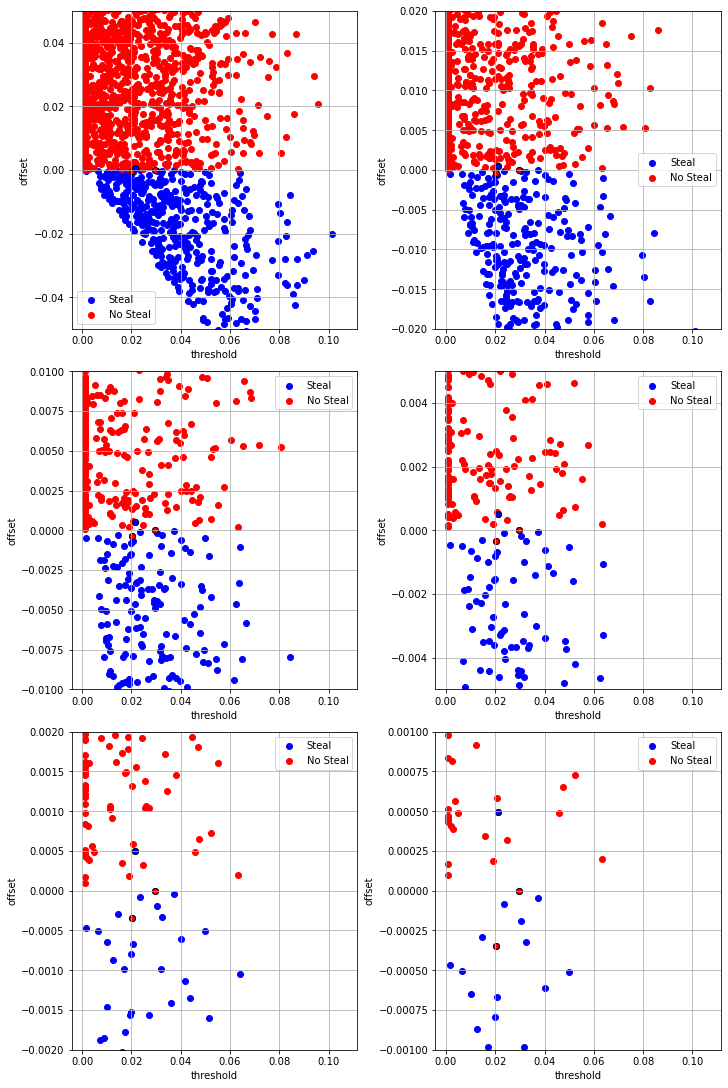

In [60]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1} Hits vs. Outs", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Steal",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="No Steal",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/hit_out_fit_offsets.png", facecolor='white')

In [17]:
check = dfc[dfc["game_id"] == "01a0cd64-6e0a-44cb-b766-5b7f0f8ca1a5"]
check2 = check[
[
        "passed",
        "offset",
        "roll",
        "threshold",
        # "threshold_plot",
        # "event_type",  # "home_score", "away_score", "top_of_inning", "inning",
        # "pitcher_mul",
        # "runner_mul",
        # "fielder_mul",  # "baserunner_count",
        # "runner_vibes", "pitcher_vibes",
        "laser",
        "runner_base_thirst",
        # "laser_thirst_term",
        # "pwatch",
        # "fwatch",
        # "incon_center",
        # "elong_center",
        # "park_factors",
        "runner_name",
        "pitcher_name",
        "fielder_name",
        # "runner_mods",
        # "pitcher_mods",
        # "fielder_mods",
        # "batting_team_mods",
        # "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        "stadium_id",
        "weather",
        # "fielder_roll",
    ]
]
check2[check2["play_count"] == 215]
# check["play_count"]
# check[check["play_count"] == 215]

,passed,offset,roll,threshold,laser,runner_base_thirst,runner_name,pitcher_name,fielder_name,season,day,game_id,play_count,stadium_id,weather
